Foltányi Kolos


# Csődelőrejelzés Többáltozós Statisztikai Módszerekkel
A csődelőrejelzés alapvető célja csődvalószínűség, illetve fizetőképességet kifejező score becslése az egyes megfigyelésekhez a magyarázó változók (pénzügyi mutatók) és a csődeseményt kifejező bináris célváltozó felhasználásával.

## Adattömörítés és klaszterezés a csődmodell adatbázison

Annak érdekében, hogy modellezési célváltozó nélkül megfelelően csoportosíthassuk a pénzügyi arculat szempontjából eltérő tulajdonsággal rendelkező vállalatokat, szükséges az első lépésben elkészített csődmodellezési adatbázison a pénzügyi mutatók adattömörítésének elvégzése főkomponenselemzés segítségével, majd a főkomponensek felhasználásával a vállalatok klaszterezése. Ennek érdekében a következő feladatokat kell elvégezni:

**1. Az előző lépésben létrehozott pénzügyi mutatók adattömörítése főkomponenselemzés segítségével** <br>
**2. A főkomponensértékek alapján a vállalatok klaszterezése k-közép algoritmussal** <br>
**3. Diszkriminanciaanalízis segítségével a fentiekben elvégzett klaszterezés statisztikai megfelelőségének tesztelése**

A kiinduló adatbázist az elősző lépésben előállított `database.xlsx` file-ból olvassuk be egy dataframe-be.

In [1]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


pd.options.display.float_format = '{:.3f}'.format

database = pd.read_excel('database.xlsx', index_col=0)

database.head()

,ROE,ROA,EBITDA,ROS,ARBEV_ARANYOS_EBITDA,ESZK_ARANYOS_ARBEV,KESZLET_FORG_SEB,VEVO_FORG_SEB,LIKVID_RATA,LIKVID_GYORSRATA,...,CASH_FLOW_ARBEV_RATA,MFO_NAGYSAG,ARBEV_NAGYSAG,ARBEV_NOVEK,TOKE_ELLAT,FORGO_ESZK_ARANYA,LIKVID_PENZESZK_ARANYA,FORGO_TOKE_ARANY,VEVO_SZALLITO_ARANY,CSOD
0,0.031,0.016,0.034,0.101,0.101,0.337,18.119,105.374,0.230,0.119,...,0.065,11.229,9.905,0.927,2.097,0.053,0.433,-0.102,0.005,0
1,2.107,0.704,0.868,0.644,0.644,3.831,36045.429,6.938,1.104,1.104,...,0.553,10.058,11.787,1.010,0.023,0.995,0.184,0.093,0.901,0
2,0.132,0.039,0.056,0.021,0.021,2.740,30.380,3.946,1.326,1.180,...,0.019,9.687,10.667,1.127,0.934,0.799,0.045,0.196,0.978,0
3,0.053,0.047,0.075,0.064,0.064,1.162,11.768,6.101,9.129,7.849,...,0.063,13.068,13.239,0.971,0.398,0.719,0.589,0.641,2.469,0
4,0.115,0.045,0.355,0.222,0.222,1.597,109.840,5.976,0.567,0.539,...,0.216,11.339,11.612,1.558,1.567,0.239,0.030,-0.182,0.406,0


## **1. Az előző lépésben létrehozott pénzügyi mutatók adattömörítése főkomponenselemzés segítségével**
A főkomponensek létrehozásánál figyelembe kell venni, hogy a tömörített változók üzleti szempontból hasonló üzenetet hordozzanak. A létrehozott főkomponensek validálása a korrelációs együtthatók, a megőrzött varianciahányadok, valamint a főkomponens-képzés további követelményeinek teljesülésének vizsgálatával történik.

Definiáljuk először a `runPCA` függvényt, amely a megadott változókon főkomponenselemzést végez:

In [2]:
def runPCA(features):
    x = database[features]
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=len(features))
    ans = pca.fit_transform(x)
    return (ans, pca)

A főkomponens-képzés követelményeinek teljesülését a korrelációs mátrix, a varianciahányadok, valamint a Kaiser-Meier-Olkin minta megfelelőségi mértéke alapján vizsgáljuk. Ezek megképzését az alábbi függvények segítik:

In [3]:
def parwisePearson(db, cols=None):
    cols = cols or db.columns
    ans = [pearsonr(db[x], db[y]) for x in cols for y in cols]
    n = len(cols)
    corm = np.array([x[0] for x in ans]).reshape(n, n)
    sigm = np.array([x[1] for x in ans]).reshape(n, n)
    cor = pd.DataFrame(corm, columns=cols, index=cols)
    sig = pd.DataFrame(sigm, columns=cols, index=cols)
    return (cor, sig)

def varianceExplained(pca):
    return (pca.explained_variance_, pca.explained_variance_ratio_)

def kmo(db, cols):
    x = db[cols]
    _, kmo = calculate_kmo(x)
    return kmo

def bartlettTest(db, cols):
    x = db[cols]
    chi2, p = calculate_bartlett_sphericity(x)
    return (chi2, p)

Az eredmények logolását pedig a következő függvények segítik:

In [4]:
def printCorrelation(features):
    cor, sig = parwisePearson(database, features)
    print('Correlation Matrix:')
    display(cor)
    print('\nSignificance:')
    display(sig)

def printVariance(pca):
    print('\n\nVariance Explained:')
    var, rat = varianceExplained(pca)
    rat *= 100
    cols = [f'PC{i+1}' for i in range(pca.n_components)]
    inds = ['Total Variance:', '% of Variance:']
    df = pd.DataFrame([var, rat], columns=cols, index=inds)
    display(df)
    print('\nScree Plot:')
    df.iloc[0,:].plot();

def printKMOAndBartlett(features):
    print('\nKMO:', kmo(database, features))
    print('\nBartlett\'s Test:')
    chi2, p = bartlettTest(database, features)
    print('   Chi-Square: ', chi2)
    print('   p-value: ', p)

def printStats(features, pca):
    printCorrelation(features)
    printKMOAndBartlett(features)
    printVariance(pca)

Ezen metódusokkal megalkothatjuk a főkomponenseket, melyeket egy új dataframe-be mentünk el:

In [5]:
compressed = pd.DataFrame()

**Eszközjövedelmezőségi főkomponens** <br>
ROA, EBITDA jövedelmezőség, Dinamikus jövedelmezőségi ráta

Correlation Matrix:


,ROA,EBITDA,DIN_JOVED_RATA
ROA,1.000,0.944,0.974
EBITDA,0.944,1.000,0.968
DIN_JOVED_RATA,0.974,0.968,1.000



Significance:


,ROA,EBITDA,DIN_JOVED_RATA
ROA,0.000,0.000,0.000
EBITDA,0.000,0.000,0.000
DIN_JOVED_RATA,0.000,0.000,0.000



KMO: 0.7419505405673928

Bartlett's Test:
   Chi-Square:  5739.648000112813
   p-value:  0.0


Variance Explained:


,PC1,PC2,PC3
Total Variance:,2.927,0.057,0.019
% of Variance:,97.473,1.889,0.638



Scree Plot:


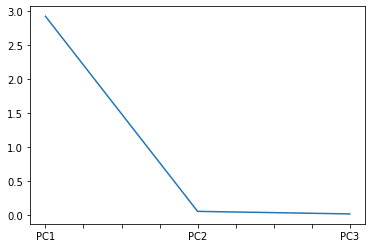

In [6]:
features = ['ROA', 'EBITDA', 'DIN_JOVED_RATA']

tx, pca = runPCA(features)

compressed['PCA_ESZK_JOVED'] = [x[0] for x in tx]

printStats(features, pca)

**Bevételarányos jövedelmezőségi főkomponens – bevételtermelés hatékonysága**<br>
ROS, Árbevételarányos EBITDA, Cash flow / Nettó árbevétel


Correlation Matrix:


,ROS,EBITDA,CASH_FLOW_ARBEV_RATA
ROS,1.000,0.670,0.886
EBITDA,0.670,1.000,0.647
CASH_FLOW_ARBEV_RATA,0.886,0.647,1.000



Significance:


,ROS,EBITDA,CASH_FLOW_ARBEV_RATA
ROS,0.000,0.000,0.000
EBITDA,0.000,0.000,0.000
CASH_FLOW_ARBEV_RATA,0.000,0.000,0.000



KMO: 0.6908632887191525

Bartlett's Test:
   Chi-Square:  2153.923659978889
   p-value:  0.0


Variance Explained:


,PC1,PC2,PC3
Total Variance:,2.477,0.413,0.113
% of Variance:,82.476,13.745,3.779



Scree Plot:


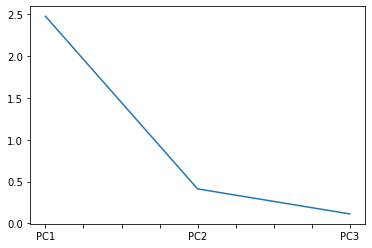

In [7]:
features = ['ROS', 'EBITDA', 'CASH_FLOW_ARBEV_RATA']

tx, pca = runPCA(features)

compressed['PCA_BEV_ARANYOS_JOVED'] = [x[0] for x in tx]

printStats(features, pca)

**Eladósodottság főkomponens – sajáterős vállalatfinanszírozás mértéke**<br>
Saját vagyon aránya, Eladósodottság mértéke, Nettó forgótőke aránya

Correlation Matrix:


,SAJAT_VAGYON_ARANYA,ELADOS_MERTEKE,FORGO_TOKE_ARANY
SAJAT_VAGYON_ARANYA,1.000,-0.931,0.683
ELADOS_MERTEKE,-0.931,1.000,-0.696
FORGO_TOKE_ARANY,0.683,-0.696,1.000



Significance:


,SAJAT_VAGYON_ARANYA,ELADOS_MERTEKE,FORGO_TOKE_ARANY
SAJAT_VAGYON_ARANYA,0.000,0.000,0.000
ELADOS_MERTEKE,0.000,0.000,0.000
FORGO_TOKE_ARANY,0.000,0.000,0.000



KMO: 0.6879168259893406

Bartlett's Test:
   Chi-Square:  2686.099799451646
   p-value:  0.0


Variance Explained:


,PC1,PC2,PC3
Total Variance:,2.548,0.385,0.069
% of Variance:,84.862,12.830,2.307



Scree Plot:


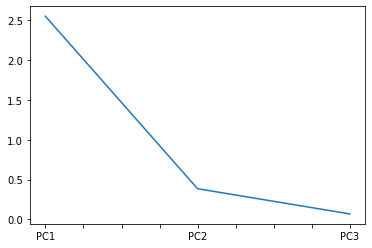

In [8]:
features = ['SAJAT_VAGYON_ARANYA', 'ELADOS_MERTEKE', 'FORGO_TOKE_ARANY']

tx, pca = runPCA(features)


compressed['PCA_ELAD_MERTEKE'] = [x[0] for x in tx]

printStats(features, pca)

**Tőkeellátottság főkomponens – tőkeszerkezet megfelelősége**<br>
Bonitás, Tőkeellátottsági mutató

Correlation Matrix:


,TOKE_ELLAT,IDEGEN_SAJAT_TOKE_ARANY
TOKE_ELLAT,1.000,-0.355
IDEGEN_SAJAT_TOKE_ARANY,-0.355,1.000



Significance:


,TOKE_ELLAT,IDEGEN_SAJAT_TOKE_ARANY
TOKE_ELLAT,0.000,0.000
IDEGEN_SAJAT_TOKE_ARANY,0.000,0.000



KMO: 0.49949975000012503

Bartlett's Test:
   Chi-Square:  136.20190873494764
   p-value:  9.07715548738756e-32


Variance Explained:


,PC1,PC2
Total Variance:,1.356,0.646
% of Variance:,67.740,32.260



Scree Plot:


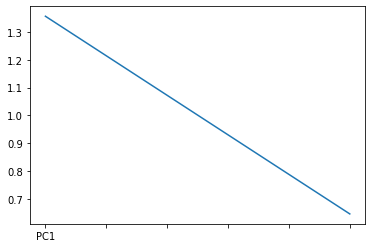

In [9]:
features = ['TOKE_ELLAT', 'IDEGEN_SAJAT_TOKE_ARANY']

tx, pca = runPCA(features)

compressed['PCA_TOKE_ELLAT'] = [x[0] for x in tx]

printStats(features, pca)

**Likviditás főkomponens – rövid lejáratú kötelezettségek visszafizetési képessége**<br>
Likviditási ráta, Likviditási gyorsráta, Készpénz likviditás

Correlation Matrix:


,LIKVID_RATA,LIKVID_GYORSRATA,KESZPENZ_LIKVID
LIKVID_RATA,1.000,0.959,0.813
LIKVID_GYORSRATA,0.959,1.000,0.848
KESZPENZ_LIKVID,0.813,0.848,1.000



Significance:


,LIKVID_RATA,LIKVID_GYORSRATA,KESZPENZ_LIKVID
LIKVID_RATA,0.000,0.000,0.000
LIKVID_GYORSRATA,0.000,0.000,0.000
KESZPENZ_LIKVID,0.000,0.000,0.000



KMO: 0.7105696818711582

Bartlett's Test:
   Chi-Square:  3773.888756420017
   p-value:  0.0


Variance Explained:


,PC1,PC2,PC3
Total Variance:,2.750,0.214,0.039
% of Variance:,91.585,7.120,1.294



Scree Plot:


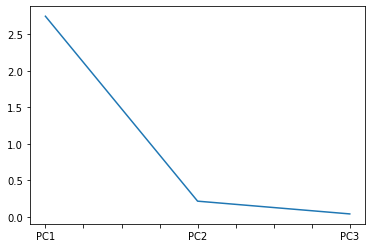

In [10]:
features = ['LIKVID_RATA', 'LIKVID_GYORSRATA', 'KESZPENZ_LIKVID']

tx, pca = runPCA(features)

compressed['PCA_LIKVID'] = [x[0] for x in tx]

printStats(features, pca)

**Méret főkomponens – a vállalat mérete**<br>
Log(Mérlegfőösszeg), Log(Árbevétel)

Correlation Matrix:


,MFO_NAGYSAG,ARBEV_NAGYSAG
MFO_NAGYSAG,1.000,0.585
ARBEV_NAGYSAG,0.585,1.000



Significance:


,MFO_NAGYSAG,ARBEV_NAGYSAG
MFO_NAGYSAG,0.000,0.000
ARBEV_NAGYSAG,0.000,0.000



KMO: 0.4994997500001255

Bartlett's Test:
   Chi-Square:  419.3264588633775
   p-value:  1.7141559571880565e-93


Variance Explained:


,PC1,PC2
Total Variance:,1.586,0.416
% of Variance:,79.235,20.765



Scree Plot:


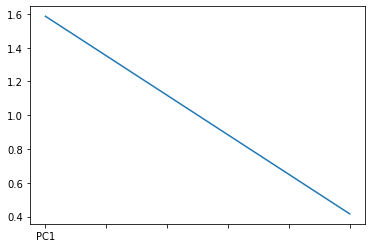

In [11]:
features = ['MFO_NAGYSAG', 'ARBEV_NAGYSAG']

tx, pca = runPCA(features)

compressed['PCA_MERET'] = [x[0] for x in tx]

printStats(features, pca)

**Fedezettség főkomponens – kötelezettségek dinamikus fedezettsége**<br>
Dinamikus likviditás, Cash flow / Összes tartozás

Correlation Matrix:


,DINAMIKUS_LIKVID,CASH_FLOW_TART_RATA
DINAMIKUS_LIKVID,1.000,0.812
CASH_FLOW_TART_RATA,0.812,1.000



Significance:


,DINAMIKUS_LIKVID,CASH_FLOW_TART_RATA
DINAMIKUS_LIKVID,0.000,0.000
CASH_FLOW_TART_RATA,0.000,0.000



KMO: 0.4994997500001246

Bartlett's Test:
   Chi-Square:  1077.2639475727412
   p-value:  1.4449572915689799e-236


Variance Explained:


,PC1,PC2
Total Variance:,1.814,0.188
% of Variance:,90.611,9.389



Scree Plot:


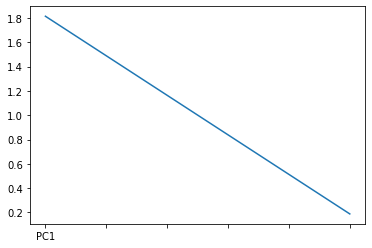

In [12]:
features = ['DINAMIKUS_LIKVID', 'CASH_FLOW_TART_RATA']

tx, pca = runPCA(features)

compressed['PCA_FEDEZETTSEG'] = [x[0] for x in tx]

printStats(features, pca)

## 2. A főkomponensértékek alapján a vállalatok klaszterezése k-közép algoritmussal
Az így kiszámolt 7 főkomponens segítségével a továbbiakban klaszterelemzést tudunk végezni.

In [13]:
compressed.head()

,PCA_ESZK_JOVED,PCA_BEV_ARANYOS_JOVED,PCA_ELAD_MERTEKE,PCA_TOKE_ELLAT,PCA_LIKVID,PCA_MERET,PCA_FEDEZETTSEG
0,-0.839,-0.376,0.187,-0.500,-1.060,-0.639,-0.652
1,4.274,3.891,1.213,0.163,-0.749,-0.154,4.382
2,-0.664,-0.654,0.331,-0.134,-0.745,-1.008,-0.686
3,-0.557,-0.394,-2.409,0.032,2.940,2.292,0.329
4,0.665,0.951,0.480,-0.333,-0.968,0.421,-0.333


A K-Means klaszterezés a következőképpen történik:

In [14]:
kmeans = KMeans(n_clusters=10).fit(compressed)
centroids = kmeans.cluster_centers_
clustered = compressed.copy()
clustered['CLUSTER'] = kmeans.labels_

A klaszter centroidok főkomponens-átlag értékei:

In [15]:
display(pd.DataFrame(centroids, columns=compressed.columns).transpose())


,0,1,2,3,4,5,6,7,8,9
PCA_ESZK_JOVED,0.892,-1.040,-0.392,3.490,-0.549,3.329,0.509,-0.725,-2.941,-0.749
PCA_BEV_ARANYOS_JOVED,1.009,-0.786,-0.062,2.541,-0.527,2.347,0.849,-0.622,-3.102,-0.319
PCA_ELAD_MERTEKE,-0.875,2.365,-0.140,-1.854,1.047,0.551,-2.425,-1.021,3.034,-1.796
PCA_TOKE_ELLAT,-0.079,2.717,-0.389,0.081,-0.995,-0.080,0.065,-0.109,2.543,-0.159
PCA_LIKVID,-0.139,-0.802,-0.579,1.314,-0.841,-0.596,5.305,-0.211,-0.957,4.134
PCA_MERET,-0.532,-0.557,2.150,-0.542,-0.134,-0.192,-0.617,-0.491,-0.155,0.122
PCA_FEDEZETTSEG,0.526,-0.818,-0.444,3.508,-0.678,0.447,3.660,-0.583,-1.279,0.198


A klaszterek méretei:

In [16]:
pd.DataFrame(clustered.groupby('CLUSTER').count().iloc[:,0].values, columns=['COUNT'])

,COUNT
0,147
1,53
2,135
3,47
4,218
5,78
6,40
7,171
8,64
9,47


## 3. Diszkriminanciaanalízis segítségével a fentiekben elvégzett klaszterezés statisztikai megfelelőségének tesztelése
A klaszterezés eredményének helytállóságát diszkriminancia analízissel ellenőrizzük. Ezt r-ben a legkönnyeb, ezért először exportáljuk a táblánkat, amely tartalmazza a klaszterezés eredményét.

In [17]:
display(clustered.head())

clustered.to_excel('clustered.xlsx', index=False)

,PCA_ESZK_JOVED,PCA_BEV_ARANYOS_JOVED,PCA_ELAD_MERTEKE,PCA_TOKE_ELLAT,PCA_LIKVID,PCA_MERET,PCA_FEDEZETTSEG,CLUSTER
0,-0.839,-0.376,0.187,-0.500,-1.060,-0.639,-0.652,4
1,4.274,3.891,1.213,0.163,-0.749,-0.154,4.382,3
2,-0.664,-0.654,0.331,-0.134,-0.745,-1.008,-0.686,4
3,-0.557,-0.394,-2.409,0.032,2.940,2.292,0.329,9
4,0.665,0.951,0.480,-0.333,-0.968,0.421,-0.333,0


Majd r-ben a `manova` függvénnyel tudjuk elvégezni az ANOVA tesztet:

```r
library(readxl)

# Az adatok beolvasása
clustered <- read_excel("clustered.xlsx")

# A CLUSTER értéket kategória változóként akarjuk beolvasni:
clustered$CLUSTER <- factor(clustered$CLUSTER)

# A változók összefűzése
vars <- cbind(
  PCA_ESZK_JOVED, 
  PCA_BEV_ARANYOS_JOVED, 
  PCA_ELAD_MERTEKE, 
  PCA_TOKE_ELLAT, 
  PCA_LIKVID, 
  PCA_MERET, 
  PCA_FEDEZETTSEG
)

# Anova elemzés
test <- manova(vars ~ CLUSTER, data = clustered)

# A végeredmény kiírása
summary.aov(test)
```

Melynek eredménye a következő lett:

```
Response PCA_ESZK_JOVED :
             Df  Sum Sq Mean Sq F value    Pr(>F)    
CLUSTER       9 2384.85 264.983  486.41 < 2.2e-16 ***
Residuals   990  539.33   0.545                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PCA_BEV_ARANYOS_JOVED :
             Df  Sum Sq Mean Sq F value    Pr(>F)    
CLUSTER       9 1684.48 187.164   234.6 < 2.2e-16 ***
Residuals   990  789.81   0.798                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PCA_ELAD_MERTEKE :
             Df  Sum Sq Mean Sq F value    Pr(>F)    
CLUSTER       9 1980.69 220.076   385.5 < 2.2e-16 ***
Residuals   990  565.18   0.571                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PCA_TOKE_ELLAT :
             Df  Sum Sq Mean Sq F value    Pr(>F)    
CLUSTER       9 1048.59 116.510  376.68 < 2.2e-16 ***
Residuals   990  306.21   0.309                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PCA_LIKVID :
             Df  Sum Sq Mean Sq F value    Pr(>F)    
CLUSTER       9 2334.70 259.411  622.03 < 2.2e-16 ***
Residuals   990  412.87   0.417                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PCA_MERET :
             Df Sum Sq Mean Sq F value    Pr(>F)    
CLUSTER       9 774.14  86.016  105.06 < 2.2e-16 ***
Residuals   990 810.57   0.819                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PCA_FEDEZETTSEG :
             Df  Sum Sq Mean Sq F value    Pr(>F)    
CLUSTER       9 1497.46 166.385  523.31 < 2.2e-16 ***
Residuals   990  314.76   0.318                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

A szokásos szignifikancia szinteken kijelenthetjük, hogy valamennyi főkomponenst megvizsgálva a létrejött csoportok között a főkomponens-átlagok szignifikánsan eltérnek egymástól. **A klaszterezés eredményeképpen előállt vállalatcsoportok tehát jelentősen különböznek egymástól.**